In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load and format data

Loading and formatting all the relevant data, also grabbing the top 200 peaks by LogFC per cell type (stored in count_data_topdiff)

In [2]:
fimo_file_list = []
fimo_counts = dict()
fimo_base_dir = "/oak/stanford/groups/akundaje/projects/dnalm_benchmark/cell_line_data/"
cell_line_list = ["K562", "GM12878", "HEPG2", "IMR90", "H1ESC"]
for cell_line in cell_line_list:
    fimo_counts[cell_line] = pd.read_csv(fimo_base_dir + cell_line + "/fimo_out/fimo.tsv", sep="\t")[["motif_id", "sequence_name", "start", "stop", "p-value", "q-value", "score"]]

In [3]:
fimo_counts["K562"]

motif_id sequence_name  \
0                                       ZN441.H12CORE.1.P.C          chr2   
1                                       ZN441.H12CORE.1.P.C         chr18   
2                                       ZN441.H12CORE.1.P.C          chr1   
3                                       ZN441.H12CORE.1.P.C         chr19   
4                                       ZN441.H12CORE.1.P.C          chr3   
...                                                     ...           ...   
11248320                                DLX6.H12CORE.0.SM.B          chr1   
11248321                                DLX6.H12CORE.0.SM.B          chr3   
11248322  # FIMO (Find Individual Motif Occurrences): Ve...           NaN   
11248323  # The format of this file is described at http...           NaN   
11248324  # fimo /oak/stanford/groups/akundaje/projects/...           NaN   

                start         stop       p-value       q-value    score  
0            812936.0     812966.0  7.690000e-20  2.650000e-14  59.0102  
1           1406540.0    1406570.0  7.690000e-20  2.650000e-14  59.0102  
2           1983704.0    1983734.0  7.690000e-20  2.650000e-14  59.0102  
3           3307756.0    3307786.0  7.690000e-20  2.650000e-14  59.0102  
4           6214353.0    6214383.0  7.690000e-20  2.650000e-14  59.0102  
...               ...          ...           ...           ...      ...  
11248320  162742313.0  162742325.0  1.000000e-04  1.000000e+00  11.3396  
11248321  197443904.0  197443916.0  1.000000e-04  1.000000e+00  11.3396  
11248322          NaN          NaN           NaN           NaN      NaN  
11248323          NaN          NaN           NaN           NaN      NaN  
11248324          NaN          NaN           NaN           NaN      NaN  

[11248325 rows x 7 columns]

In [4]:
peak_file = "/oak/stanford/groups/akundaje/projects/dnalm_benchmark/cell_line_data/top_5000_deseq_peaks.tsv"
peak_table = pd.read_csv(peak_file, sep="\t")

In [5]:
for cell_line in cell_line_list:
    peaks_df = peak_table[peak_table["Cell Type"]==cell_line][["Chr", "Start", "End"]].reset_index()
    peaks_df["index"] = ["peak"+str(i) for i in peaks_df["index"]]
    peaks_df = peaks_df.rename(columns={"index" : "peaks"})
    peaks_df = peaks_df[["Chr", "Start", "End", "peaks"]]
    print(cell_line, peaks_df.shape)
    motifs_df = fimo_counts[cell_line][fimo_counts[cell_line]['sequence_name'].isin(peaks_df['Chr'].unique())]
    motifs_df = motifs_df[['sequence_name', 'start', 'stop', 'motif_id', "p-value", "q-value", "score"]]
    motifs_df["start"] = motifs_df["start"].astype(int)
    motifs_df["stop"] = motifs_df["stop"].astype(int)
    peaks_df.to_csv(cell_line+'peaks.bed', sep='\t', header=False, index=False)
    motifs_df.to_csv(cell_line+'motifs.bed', sep='\t', header=False, index=False)

K562 (5000, 4)
GM12878 (5000, 4)
HEPG2 (5000, 4)
IMR90 (5000, 4)
H1ESC (5000, 4)


In [6]:
# command line run:
# for cell_line in "K562" "GM12878" "H1ESC" "HEPG2" "IMR90"; do bedtools intersect -a ${cell_line}peaks.bed -b ${cell_line}motifs.bed -wa -wb > ${cell_line}intersected.bed; done

In [7]:
intersected = dict()
value_counts = dict()
for cell_line in cell_line_list:
    df = pd.read_csv(cell_line+"intersected.bed", sep="\t", names=["peak_chr", "peak_start", "peak_end", "peak_name",
                                                    "motif_chr", "motif_start", "motif_end", "motif_name",
                                                                  "motif_p_value", "motif_q_value", "motif_score"])
    df = df[(df.peak_chr==df.motif_chr) & (df.peak_start < df.motif_start) & (df.peak_end > df.motif_end)]
    intersected[cell_line] = df[["motif_name", "peak_name", "motif_q_value", "motif_score"]].copy(deep=True)
    intersected[cell_line]["rank"] = intersected[cell_line].groupby(["peak_name", "motif_name"])["motif_q_value"].rank(ascending=True, method='first')
    value_counts[cell_line] = intersected[cell_line].value_counts()

In [8]:
new_intersected = dict()
for cell_line in cell_line_list:
    new_intersected[cell_line] = intersected[cell_line][intersected[cell_line]["rank"]<=5].copy(deep=True)
    new_intersected[cell_line]["-log10_q_value"] = -np.log10(new_intersected[cell_line]["motif_q_value"])
    new_intersected[cell_line] = new_intersected[cell_line][["peak_name", "motif_name", "-log10_q_value"]]

In [9]:
k562_table = new_intersected["K562"].pivot_table(index='motif_name', columns='peak_name', 
                                                 values='-log10_q_value', aggfunc='sum', fill_value=0)
imr90_table = new_intersected["IMR90"].pivot_table(index='motif_name', columns='peak_name', 
                                                 values='-log10_q_value', aggfunc='sum', fill_value=0)
hepg2_table = new_intersected["HEPG2"].pivot_table(index='motif_name', columns='peak_name', 
                                                 values='-log10_q_value', aggfunc='sum', fill_value=0)
h1esc_table = new_intersected["H1ESC"].pivot_table(index='motif_name', columns='peak_name', 
                                                 values='-log10_q_value', aggfunc='sum', fill_value=0)
gm12878_table = new_intersected["GM12878"].pivot_table(index='motif_name', columns='peak_name', 
                                                 values='-log10_q_value', aggfunc='sum', fill_value=0)

In [10]:
peak_motif_counts = pd.concat([k562_table, imr90_table, hepg2_table, h1esc_table, gm12878_table], axis=1)

In [11]:
peak_motif_counts

peak_name             peak10000  peak10001  peak10002  peak10003  peak10004  \
motif_name                                                                    
AHR.H12CORE.0.P.B      0.000000   0.000000   0.000000        0.0        0.0   
AHRR.H12CORE.0.P.C     0.000000   0.000000   0.000000        0.0        0.0   
ALX1.H12CORE.0.SM.B    0.000000   0.000000   0.000000        0.0        0.0   
ALX3.H12CORE.0.SM.B    0.000000   0.000000   0.000000        0.0        0.0   
ALX3.H12CORE.1.S.B     0.000000   0.000000   0.000000        0.0        0.0   
...                         ...        ...        ...        ...        ...   
ZSC29.H12CORE.1.M.C    0.000000   0.000000   0.000000        0.0        0.0   
ZSC31.H12CORE.0.P.C    0.583359   0.000000   1.161756        0.0        0.0   
ZSC31.H12CORE.1.SM.B   0.000000   0.000000   0.510042        0.0        0.0   
ZSCA1.H12CORE.0.SM.B   0.739929   0.863279   0.000000        0.0        0.0   
ZSCA4.H12CORE.0.SM.B   0.665546   0.537602   0.000000        0.0        0.0   

peak_name             peak10005  peak10006  peak10007  peak10008  peak10009  \
motif_name                                                                    
AHR.H12CORE.0.P.B           0.0        0.0        0.0   0.000000   0.000000   
AHRR.H12CORE.0.P.C          0.0        0.0        0.0   0.000000   0.000000   
ALX1.H12CORE.0.SM.B         0.0        0.0        0.0   0.000000   0.000000   
ALX3.H12CORE.0.SM.B         0.0        0.0        0.0   0.000000   0.000000   
ALX3.H12CORE.1.S.B          0.0        0.0        0.0   0.000000   0.000000   
...                         ...        ...        ...        ...        ...   
ZSC29.H12CORE.1.M.C         0.0        0.0        0.0   0.000000   0.000000   
ZSC31.H12CORE.0.P.C         0.0        0.0        0.0   0.000000   0.000000   
ZSC31.H12CORE.1.SM.B        0.0        0.0        0.0   0.000000   0.000000   
ZSCA1.H12CORE.0.SM.B        0.0        0.0        0.0   2.394453   0.000000   
ZSCA4.H12CORE.0.SM.B        0.0        0.0        0.0   1.397940   0.688246   

peak_name             ...  peak9990  peak9991  peak9992  peak9993  peak9994  \
motif_name            ...                                                     
AHR.H12CORE.0.P.B     ...  0.000000       0.0       0.0       0.0  0.000000   
AHRR.H12CORE.0.P.C    ...  0.000000       0.0       0.0       0.0  0.000000   
ALX1.H12CORE.0.SM.B   ...  0.000000       0.0       0.0       0.0  0.000000   
ALX3.H12CORE.0.SM.B   ...  0.000000       0.0       0.0       0.0  0.000000   
ALX3.H12CORE.1.S.B    ...  0.000000       0.0       0.0       0.0  0.000000   
...                   ...       ...       ...       ...       ...       ...   
ZSC29.H12CORE.1.M.C   ...  0.000000       0.0       0.0       0.0  0.000000   
ZSC31.H12CORE.0.P.C   ...  0.000000       0.0       0.0       0.0  0.000000   
ZSC31.H12CORE.1.SM.B  ...  0.000000       0.0       0.0       0.0  0.000000   
ZSCA1.H12CORE.0.SM.B  ...  6.215168       0.0       0.0       0.0  0.000000   
ZSCA4.H12CORE.0.SM.B  ...  3.723637       0.0       0.0       0.0  0.665546   

peak_name             peak9995  peak9996  peak9997  peak9998  peak9999  
motif_name                                                              
AHR.H12CORE.0.P.B     0.000000       0.0  0.000000  0.000000       0.0  
AHRR.H12CORE.0.P.C    0.000000       0.0  0.000000  0.000000       0.0  
ALX1.H12CORE.0.SM.B   0.000000       0.0  0.000000  0.000000       0.0  
ALX3.H12CORE.0.SM.B   0.000000       0.0  0.000000  0.000000       0.0  
ALX3.H12CORE.1.S.B    0.000000       0.0  0.000000  0.000000       0.0  
...                        ...       ...       ...       ...       ...  
ZSC29.H12CORE.1.M.C   0.000000       0.0  0.000000  0.000000       0.0  
ZSC31.H12CORE.0.P.C   0.429457       0.0  0.000000  0.444906       0.0  
ZSC31.H12CORE.1.SM.B  0.417937       0.0  0.000000  0.000000       0.0  
ZSCA1.H12CORE.0.SM.B  0.000000       0.0  1.016825  0.000000       0.0  
ZSCA4.H12CORE.0.SM.B  0.000000       0.0

In [12]:
peak_motif_counts_filtered = peak_motif_counts.loc[~(peak_motif_counts < 1).all(axis=1)]
peak_motif_counts_filtered.shape

(906, 24991)

In [13]:
n = 1000
k = 100
good_motifs = []
ratios = []
for motif in list(peak_motif_counts_filtered.index):
    scores = []
    for i in range(n):
        sample_df = peak_motif_counts_filtered.sample(k, axis=1) # sampling k peaks 
        scores += [sample_df.loc[motif].sum() + 1e-3]
    scores_sorted = sorted(scores, reverse=True)
    ratio = scores_sorted[0]/scores_sorted[-1] 
    ratios.append(ratio)
    if ratio > 50:
        good_motifs += [motif]
        print(motif)

ATF2.H12CORE.1.P.B
ATF4.H12CORE.0.P.B
ATF4.H12CORE.2.SM.B
BHE40.H12CORE.1.S.C
CDX4.H12CORE.0.S.C
CEBPD.H12CORE.0.P.B
CREM.H12CORE.1.P.C
DDIT3.H12CORE.0.P.B
E2F1.H12CORE.0.P.B
E2F4.H12CORE.1.P.B
E2F4.H12CORE.2.S.B
E2F8.H12CORE.0.P.C
EGR3.H12CORE.0.PSM.A
EGR4.H12CORE.0.S.B
ERR2.H12CORE.0.PSM.A
FOXI1.H12CORE.0.SM.B
GATA1.H12CORE.0.P.B
GFI1B.H12CORE.1.S.C
GLIS2.H12CORE.0.SM.B
GRHL1.H12CORE.0.PSM.A
HES1.H12CORE.0.S.C
HES1.H12CORE.1.S.C
HES2.H12CORE.0.S.C
HEY2.H12CORE.0.S.B
HNF6.H12CORE.3.M.B
HSF1.H12CORE.0.PSM.A
HSF1.H12CORE.2.P.B
HXA1.H12CORE.1.S.B
IRF4.H12CORE.1.S.B
IRF5.H12CORE.0.SM.B
IRF7.H12CORE.1.SM.B
IRF8.H12CORE.2.SM.B
IRF9.H12CORE.0.PSM.A
JUND.H12CORE.1.SM.B
KAISO.H12CORE.1.P.B
KLF14.H12CORE.0.PSM.A
KLF16.H12CORE.0.SM.B
KMT2B.H12CORE.0.P.B
LEF1.H12CORE.0.PSM.A
LHX2.H12CORE.1.S.C
LMX1B.H12CORE.1.SM.B
LMX1B.H12CORE.2.S.B
MAX.H12CORE.2.S.C
MGAP.H12CORE.0.P.C
MLX.H12CORE.0.PM.A
MNT.H12CORE.0.PS.A
MSX1.H12CORE.1.S.C
MXI1.H12CORE.0.P.B
MYC.H12CORE.0.P.B
MYCN.H12CORE.0.PS.A
NFYA.H12CORE.0

In [14]:
# Step 2: Calculate feature variability
scaler = StandardScaler()

variable_features = peak_motif_counts_filtered[peak_motif_counts_filtered.index.isin(good_motifs)]
normalized_matrix = scaler.fit_transform(variable_features.T).T

In [15]:
# Step 3: Dimensionality reduction with PCA
pca = PCA()
reduced_features = pca.fit_transform(normalized_matrix.T).T  # Transpose for PCA

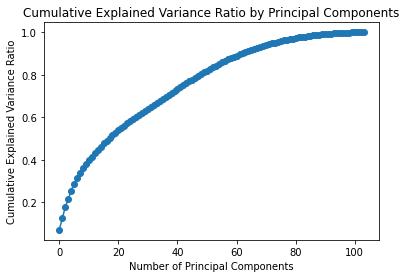

In [16]:
explained_variance_ratio = pca.explained_variance_ratio_
import numpy as np
import matplotlib.pyplot as plt

# Plot explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.show()

In [17]:
index_90 = list(cumulative_variance_ratio>0.9).index(True)
index_90 = 60
# index_90

In [18]:
percent_90 = reduced_features[:index_90,]

In [19]:
# Step 4: Cluster the features with k-means
kmeans = KMeans(n_clusters=50)  # Adjust the number of clusters as needed
feature_clusters = kmeans.fit_predict(percent_90.T)  # Transpose back for clustering

/home/users/arpitas/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [20]:
# Step 5: Create a DataFrame with cluster labels
sample_labels = peak_motif_counts.columns

In [21]:
# Create DataFrame for plotting
clustered_features_df = pd.DataFrame({
    'PC1': percent_90[0],
    'PC2': percent_90[1],
    'Cluster': feature_clusters,
    'Sample': sample_labels
})


In [22]:
cell_labels = list(k562_table.columns)+list(imr90_table.columns)+list(hepg2_table.columns)+list(h1esc_table.columns)+list(gm12878_table.columns)
cell_type = ["K562"]*len(list(k562_table.columns))
cell_type += ["IMR90"]*len(list(imr90_table.columns))
cell_type += ["HEPG2"]*len(list(hepg2_table.columns))
cell_type += ["H1ESC"]*len(list(h1esc_table.columns))
cell_type += ["GM12878"]*len(list(gm12878_table.columns))
cell_labels_df = pd.DataFrame(np.array([cell_type, cell_labels]).T, columns=["Cell Name", "Peak Num"])
cell_labels_df["Index"] = cell_labels_df["Peak Num"].str.split("peak").str[1].astype("int32")
cell_labels_df = cell_labels_df.sort_values(by="Index")
cell_labels_df

Cell Name   Peak Num  Index
9996      HEPG2      peak0      0
9997      HEPG2      peak1      1
11108     HEPG2      peak2      2
12219     HEPG2      peak3      3
13330     HEPG2      peak4      4
...         ...        ...    ...
9991      IMR90  peak24995  24995
9992      IMR90  peak24996  24996
9993      IMR90  peak24997  24997
9994      IMR90  peak24998  24998
9995      IMR90  peak24999  24999

[24991 rows x 3 columns]

In [23]:
percent_90_df = pd.DataFrame(percent_90.T)
percent_90_df["Sample"]= sample_labels
percent_90_df = pd.merge(percent_90_df, cell_labels_df, left_on=["Sample"], right_on=["Peak Num"])
percent_90_df

0         1         2         3         4         5         6  \
0     -0.099548 -0.286446 -0.575533 -0.933445  0.922901 -0.767148  6.068484   
1     -0.735805  0.003831 -0.434639 -0.477567 -0.232955 -0.602724 -0.247878   
2     -0.621949 -0.155483 -0.455920 -0.113340 -0.057753 -0.371056  0.357509   
3      0.066861  0.851628 -0.389116 -0.346839  0.276352 -0.361457 -0.525537   
4     -0.703433 -0.020058 -0.444430 -0.471254 -0.349096 -0.503939 -0.272892   
...         ...       ...       ...       ...       ...       ...       ...   
24986 -1.051988  0.033952 -0.470380 -0.177871 -0.600304  1.144106 -0.015884   
24987  0.557560 -0.657274 -0.167300  0.777994 -0.140755 -0.355186  0.316390   
24988 -0.193063  0.067684  0.910443 -0.728378 -0.250278 -0.497755 -0.096217   
24989 -1.489162  0.378574 -0.627508 -0.156133 -1.942021  7.326542  0.729678   
24990 -0.835939  0.050086 -0.443678 -0.455687 -0.314796 -0.546209 -0.287406   

              7         8         9  ...        54        55        56  \
0      1.613370  0.804815  2.538311  ... -0.067020  0.152245 -0.048184   
1      0.043654 -0.025571 -0.038141  ... -0.190115  0.141035  0.154433   
2      0.761872  0.109847  0.123030  ... -1.984396 -0.092215  0.475072   
3     -0.401816  0.075833  0.887922  ...  0.038338  0.123305  0.092103   
4     -0.022727  0.081675  0.035726  ... -0.315987 -0.226170 -0.629887   
...         ...       ...       ...  ...       ...       ...       ...   
24986  0.420731  0.191302  0.294303  ... -1.426058  0.256140 -0.046593   
24987  0.715267 -0.703228 -0.249930  ...  0.079650  0.555927  0.758663   
24988 -0.335002 -0.249666 -0.418969  ... -0.185112  0.167568 -1.261752   
24989 -0.915219  0.355618 -0.183504  ... -0.075600 -0.016593 -1.306688   
24990  0.113990  0.000632  0.173771  ... -0.006347 -0.021397  0.127458   

             57        58        59     Sample  Cell Name   Peak Num  Index  
0     -0.044790  0.525713  0.148788  peak10000       K562  peak10000  10000  
1     -0.077385 -0.027800  0.106541  peak10001       K562  peak10001  10001  
2     -0.403831  0.057775 -0.529814  peak10002       K562  peak10002  10002  
3     -0.071110 -0.081336  0.079351  peak10003       K562  peak10003  10003  
4      0.256132  0.059449  0.056022  peak10004       K562  peak10004  10004  
...         ...       ...       ...        ...        ...        ...    ...  
24986 -0.854853  0.050688 -0.060458   peak9995    GM12878   peak9995   9995  
24987 -0.423558 -0.021713 -0.403332   peak9996    GM12878   peak9996   9996  
24988  0.667443  0.032640 -0.041700   peak9997    GM12878   peak9997   9997  
24989 -3.040468  0.117058  0.129050   peak9998    GM12878   peak9998   9998  
24990 -0.071178 -0.012555  0.122532   peak9999    GM12878   peak9999   9999  

[24991 rows x 64 columns]

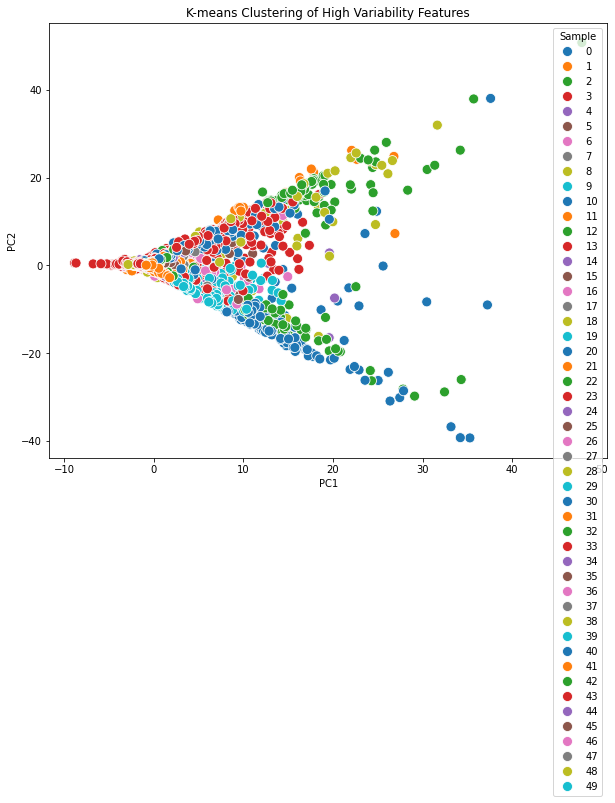

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


In [24]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=clustered_features_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=100)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering of High Variability Features')
plt.legend(title='Sample')
plt.show()

print(clustered_features_df.head())

In [25]:
labeled_cluster = pd.merge(clustered_features_df, cell_labels_df, left_on=["Sample"], right_on=["Peak Num"])[["PC1", "PC2", "Cluster", "Cell Name", "Sample"]]

In [26]:
labeled_cluster

PC1       PC2  Cluster Cell Name     Sample
0     -0.099548 -0.286446        7      K562  peak10000
1     -0.735805  0.003831       31      K562  peak10001
2     -0.621949 -0.155483       21      K562  peak10002
3      0.066861  0.851628       31      K562  peak10003
4     -0.703433 -0.020058       31      K562  peak10004
...         ...       ...      ...       ...        ...
24986 -1.051988  0.033952       44   GM12878   peak9995
24987  0.557560 -0.657274       31   GM12878   peak9996
24988 -0.193063  0.067684       31   GM12878   peak9997
24989 -1.489162  0.378574       23   GM12878   peak9998
24990 -0.835939  0.050086       31   GM12878   peak9999

[24991 rows x 5 columns]

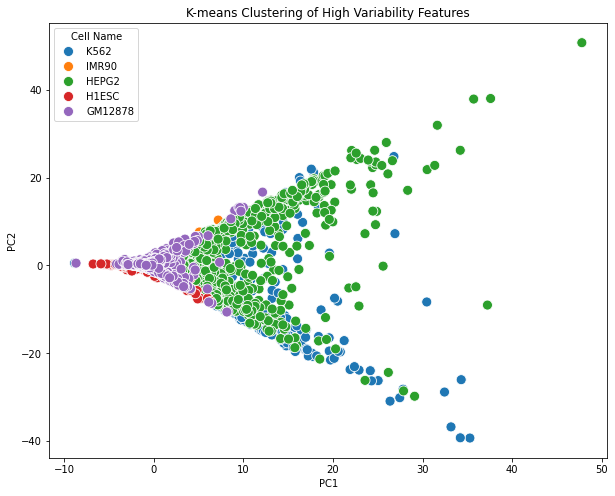

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


In [27]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=labeled_cluster, x='PC1', y='PC2', hue='Cell Name', palette='tab10', s=100)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering of High Variability Features')
plt.legend(title='Cell Name')
plt.show()
print(clustered_features_df.head())

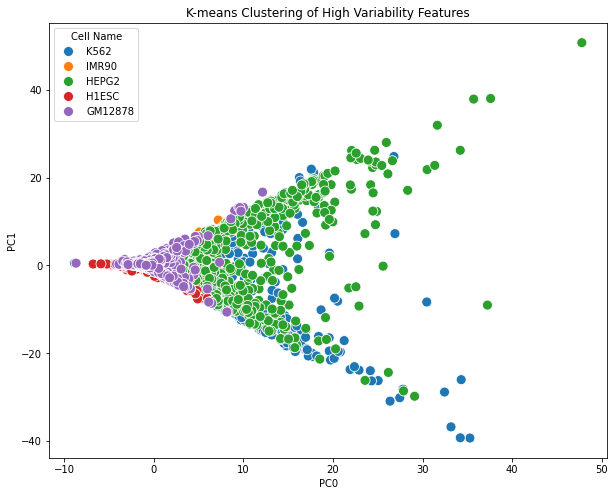

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


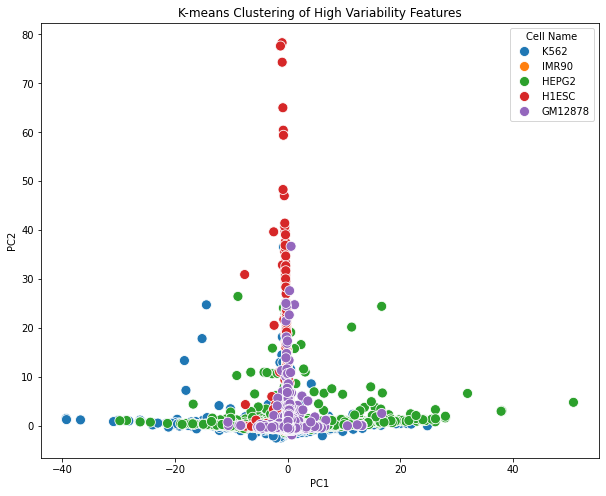

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


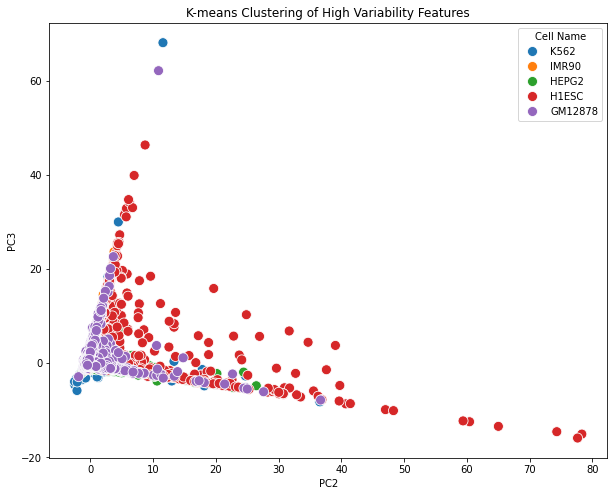

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


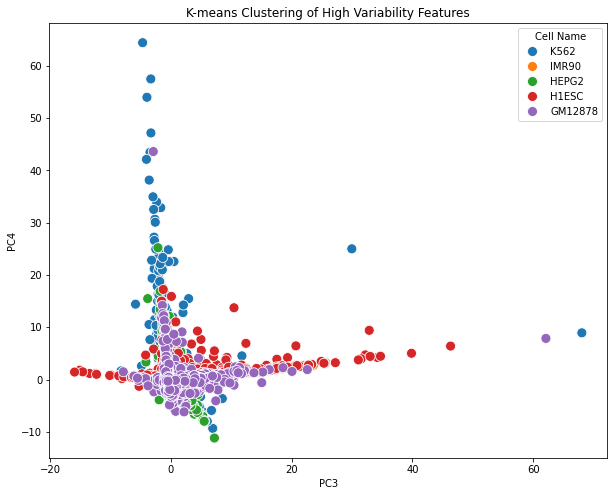

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


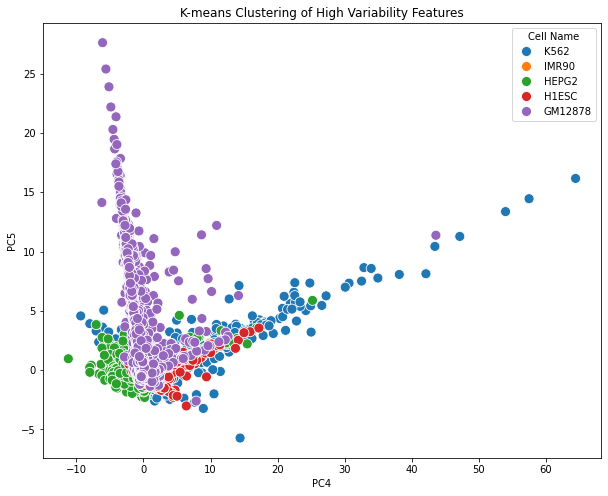

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


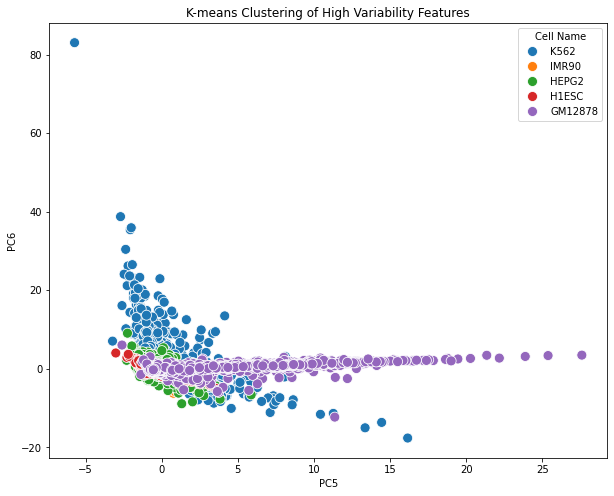

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


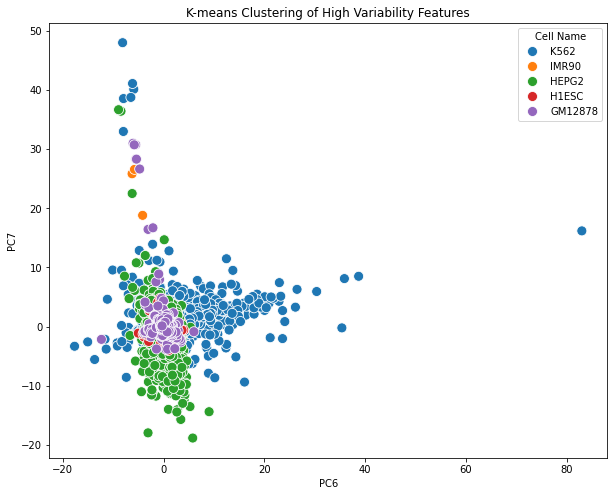

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


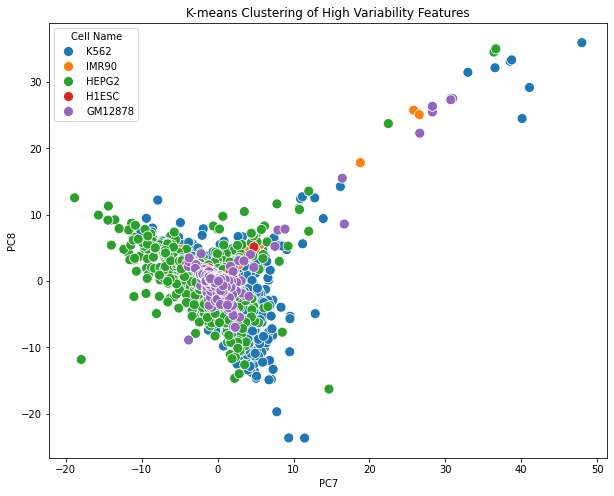

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


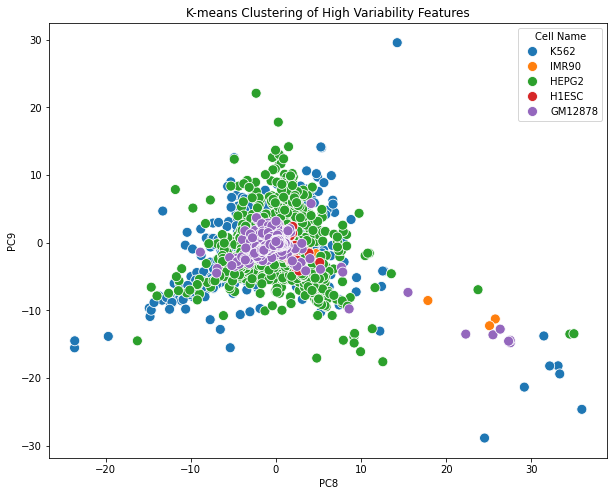

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


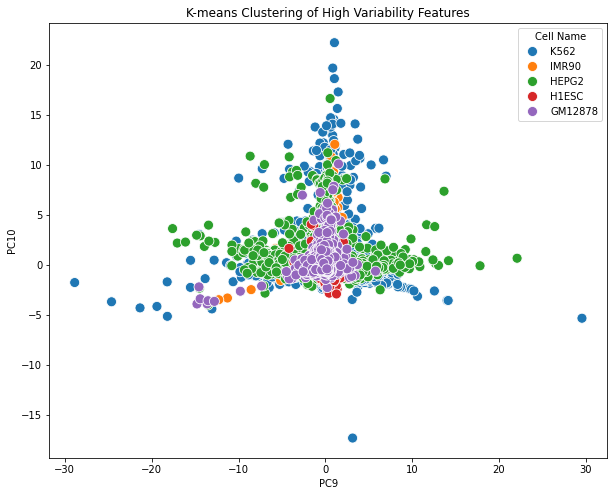

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


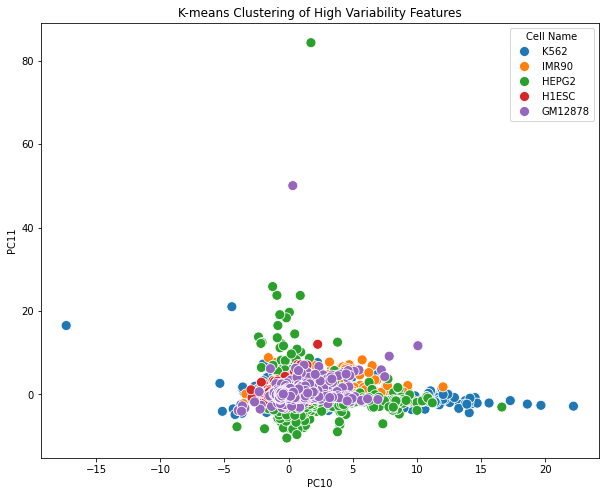

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


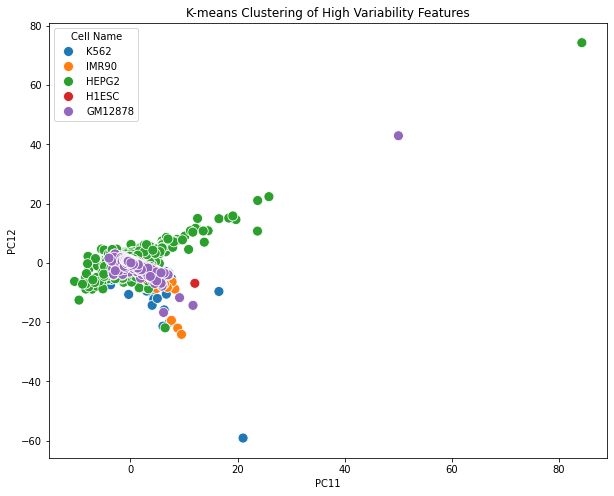

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


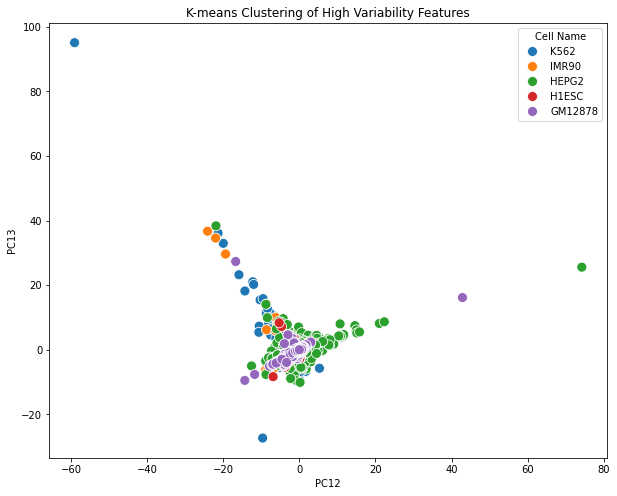

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


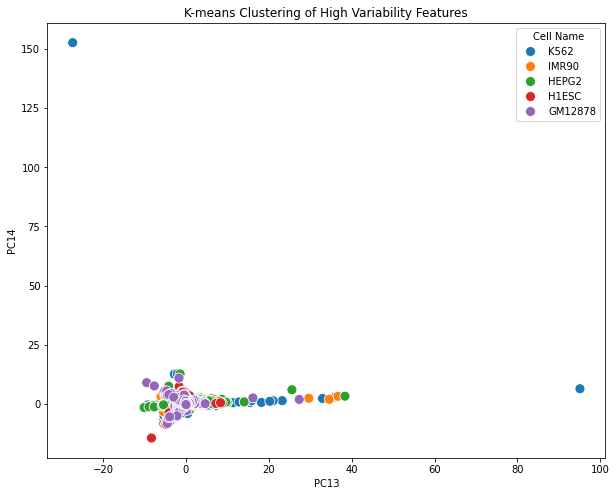

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


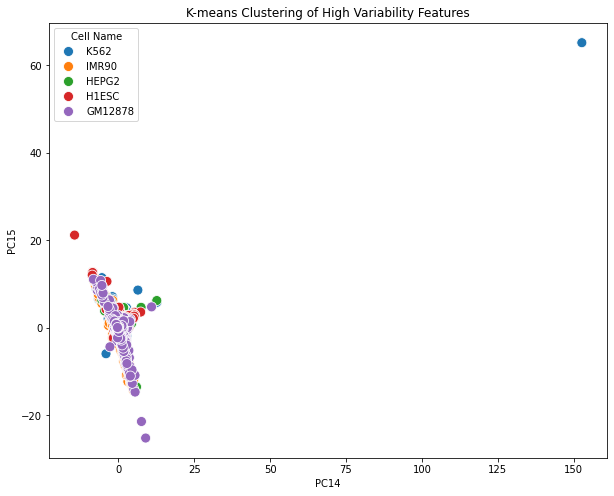

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


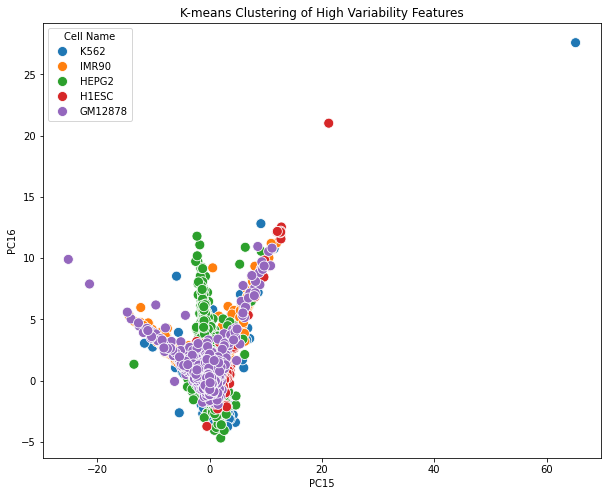

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


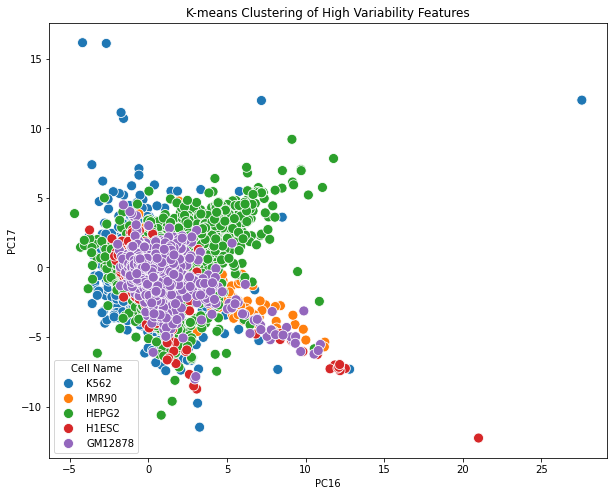

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


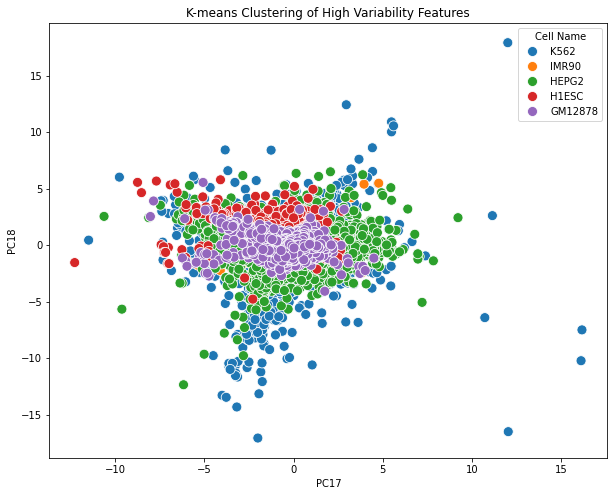

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


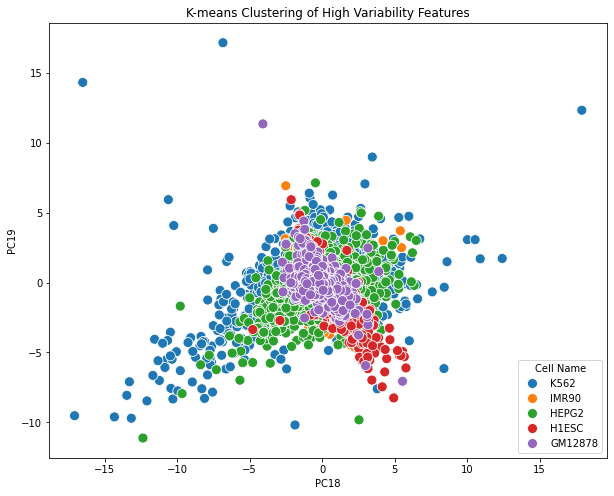

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


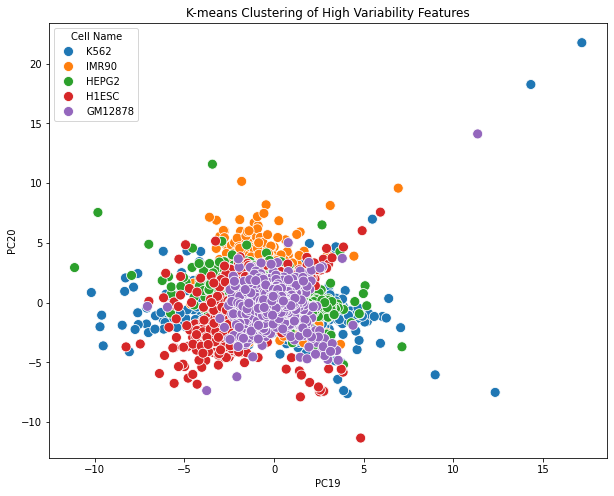

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


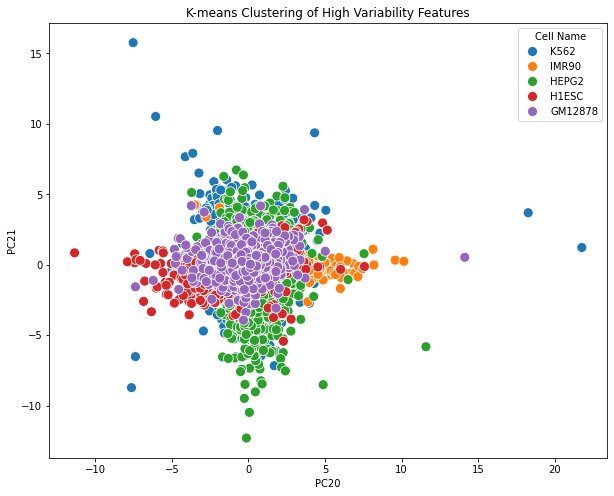

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


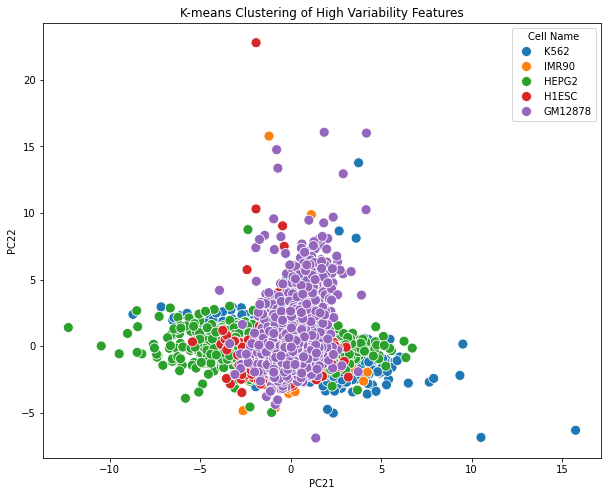

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


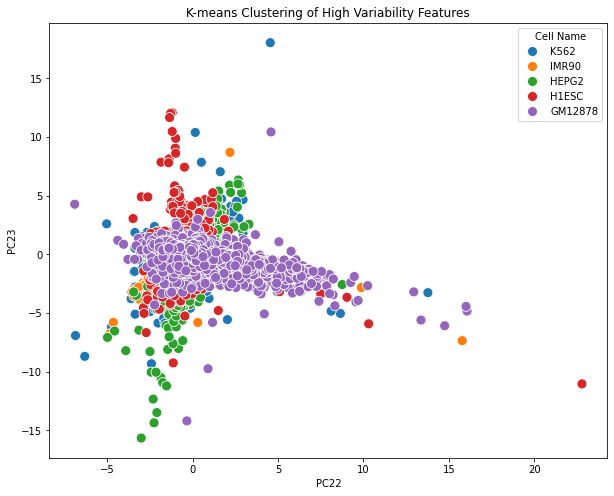

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


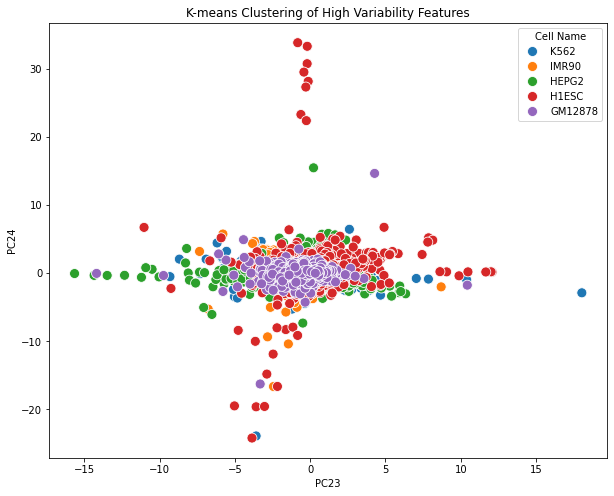

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


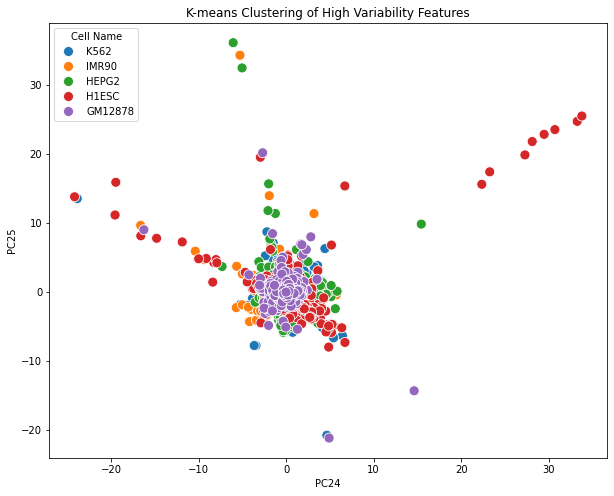

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


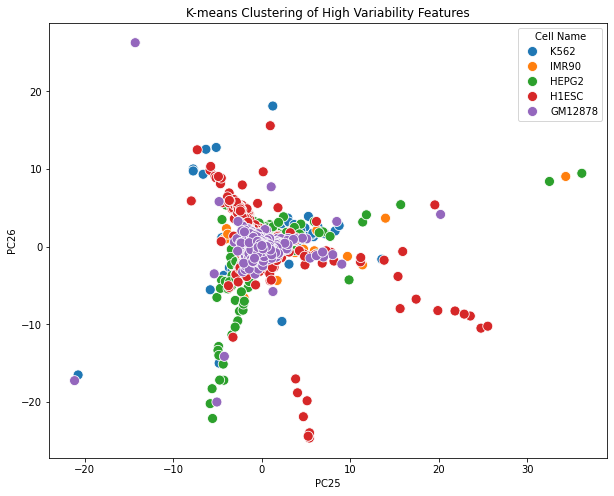

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


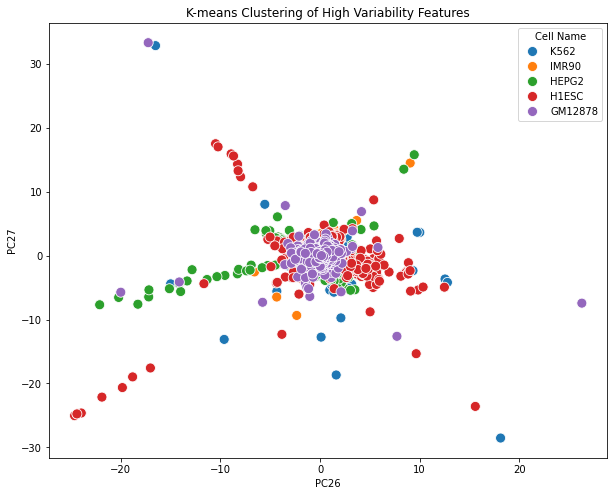

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


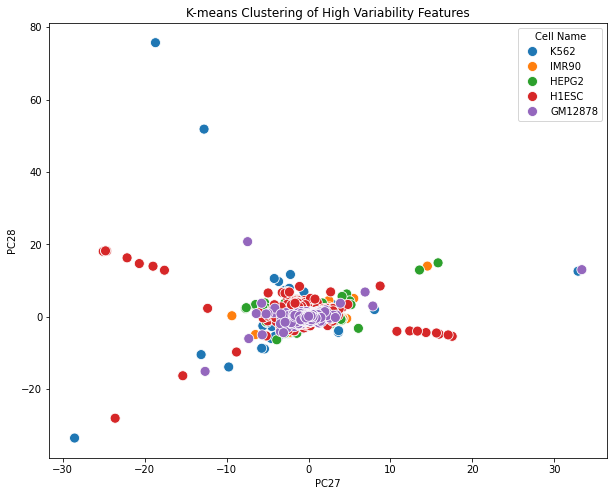

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


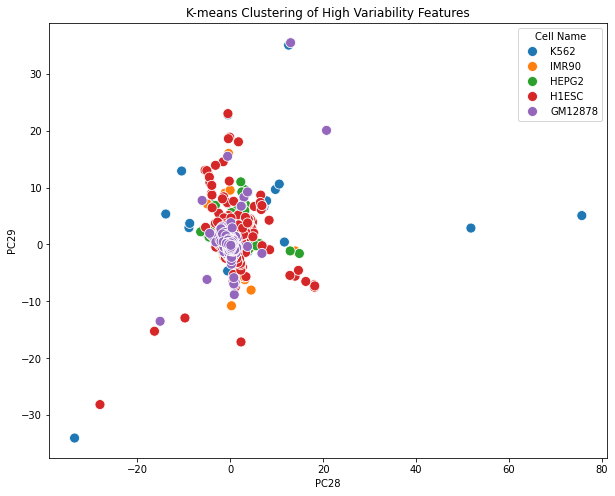

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


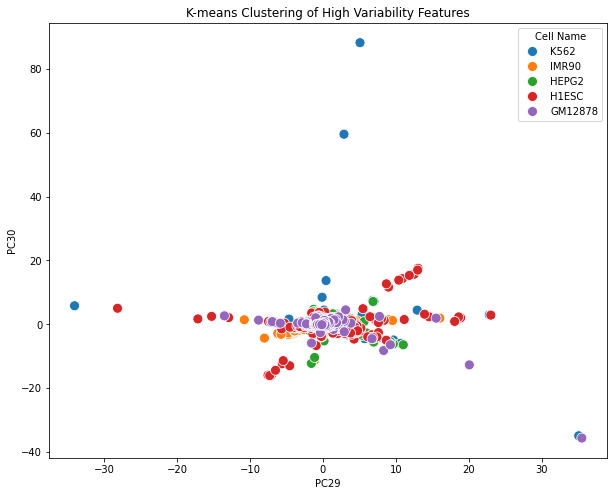

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


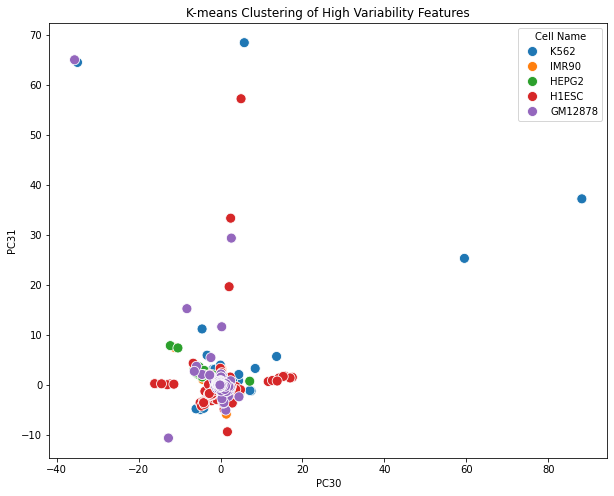

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


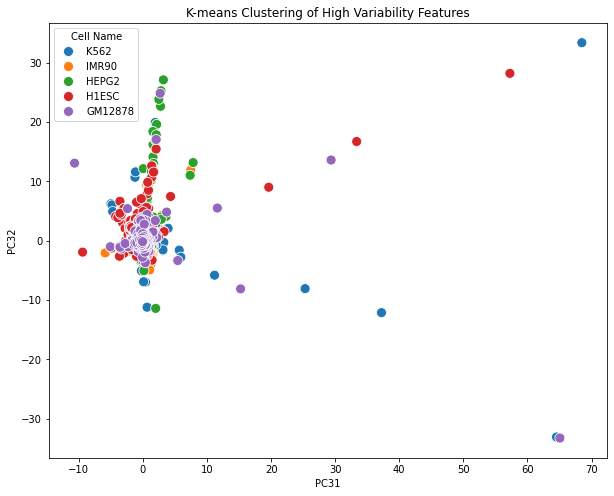

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


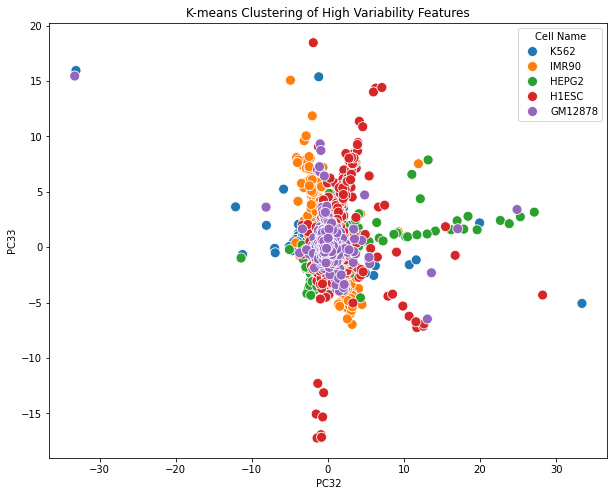

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


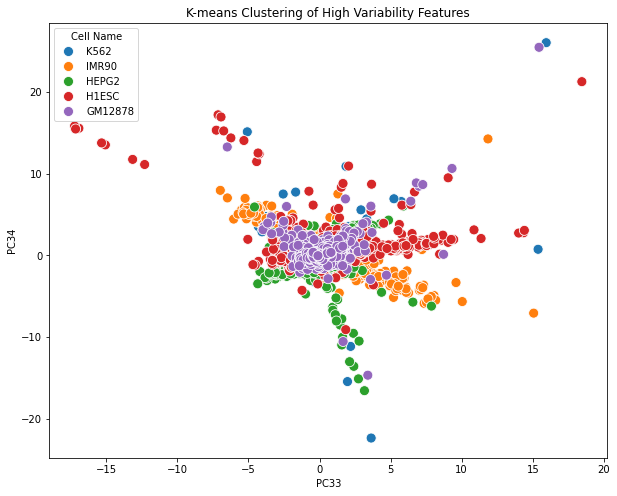

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


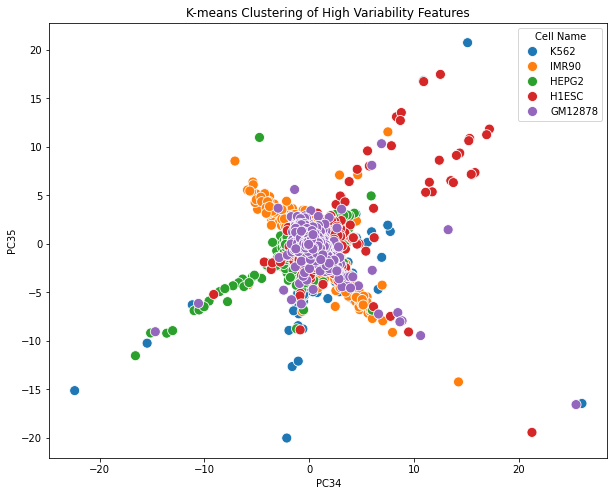

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


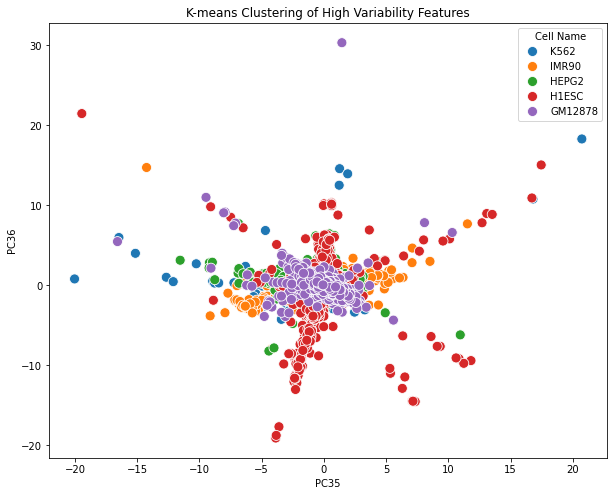

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


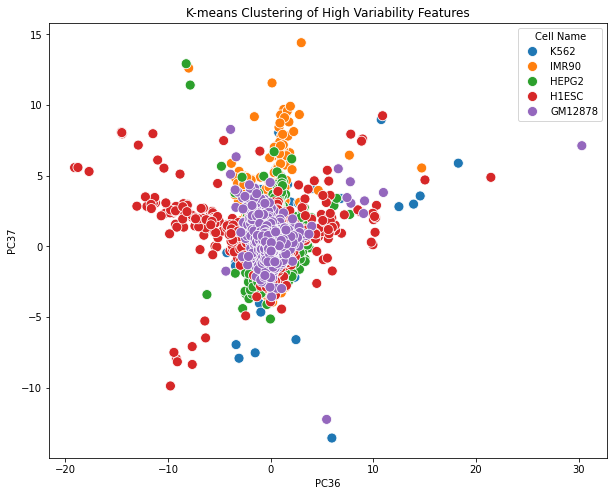

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


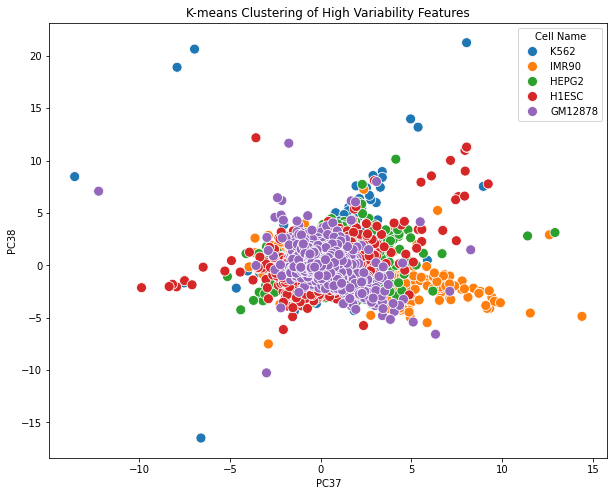

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


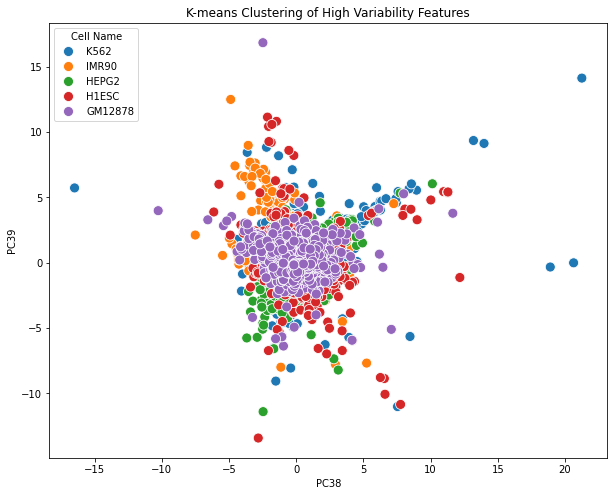

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


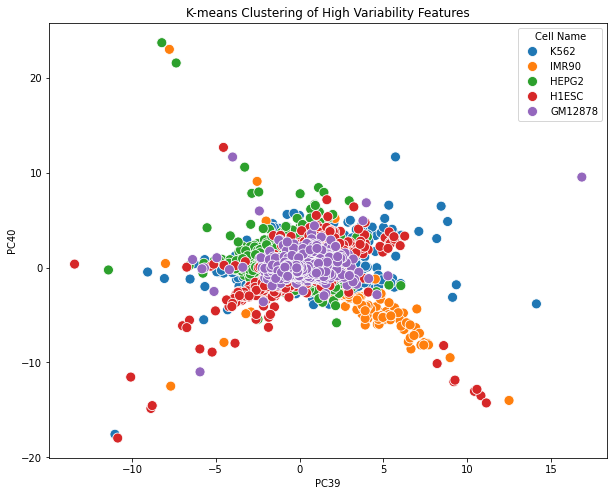

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


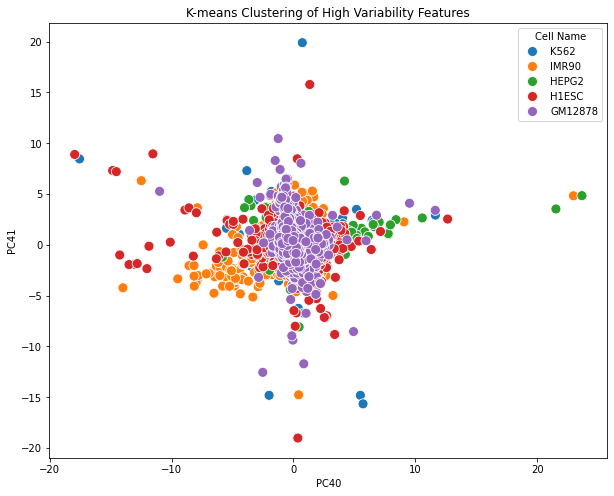

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


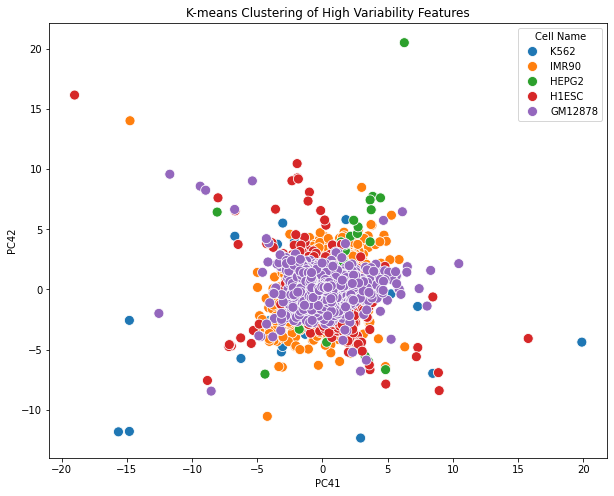

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


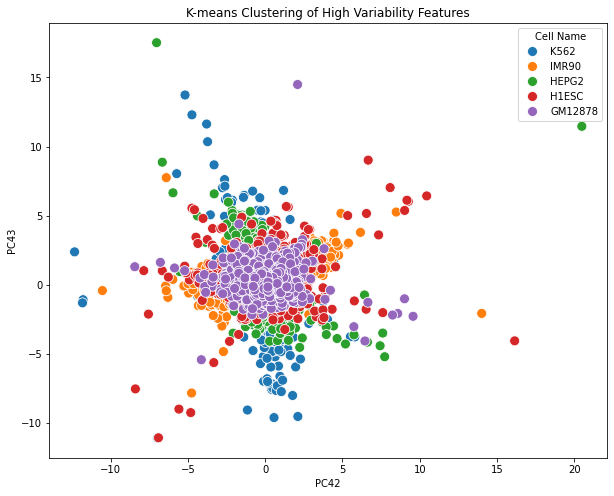

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


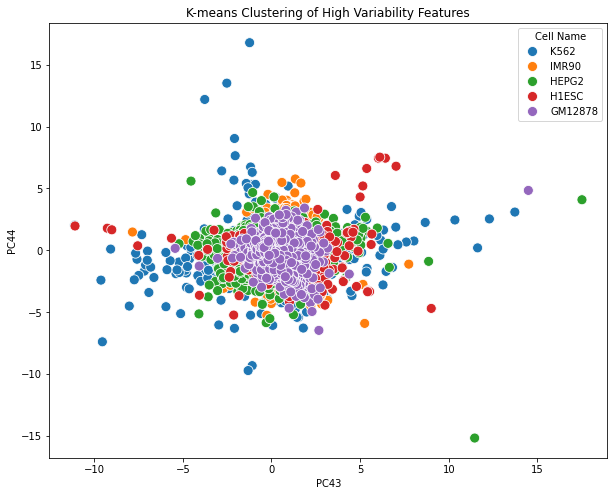

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


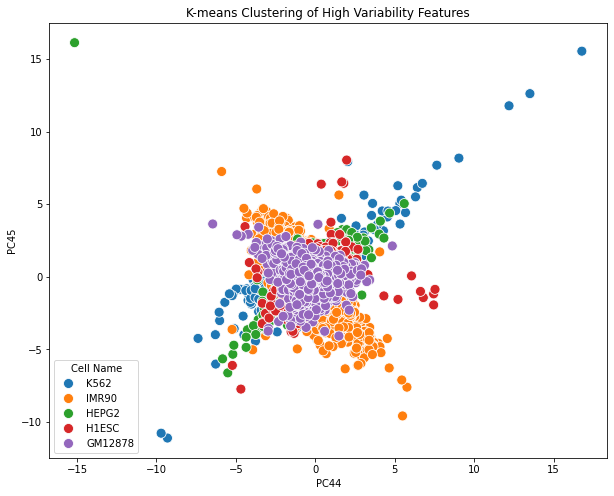

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


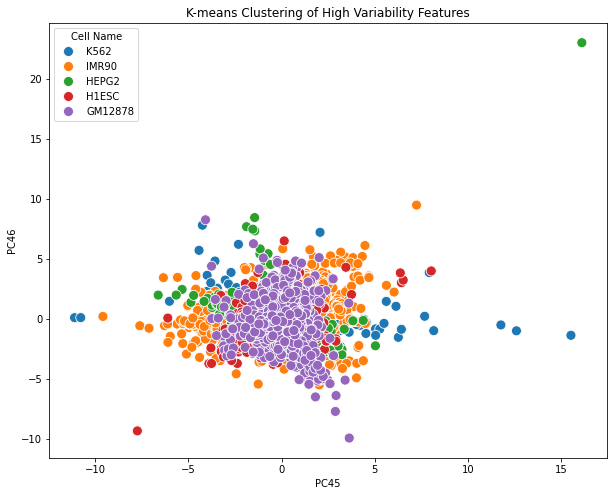

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


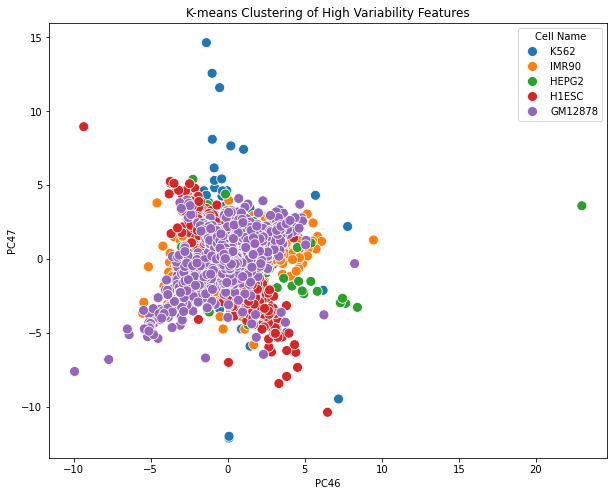

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


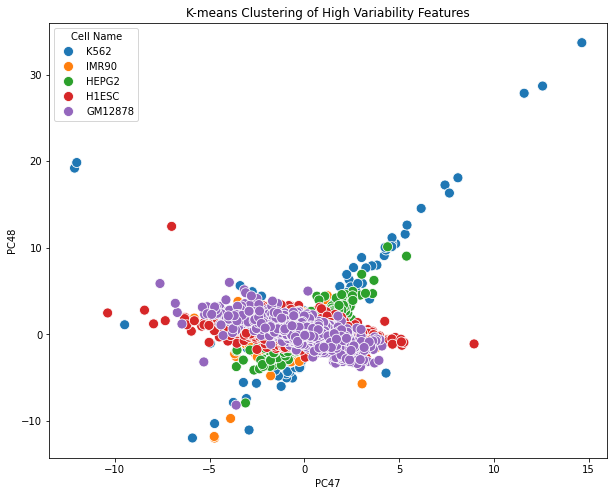

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


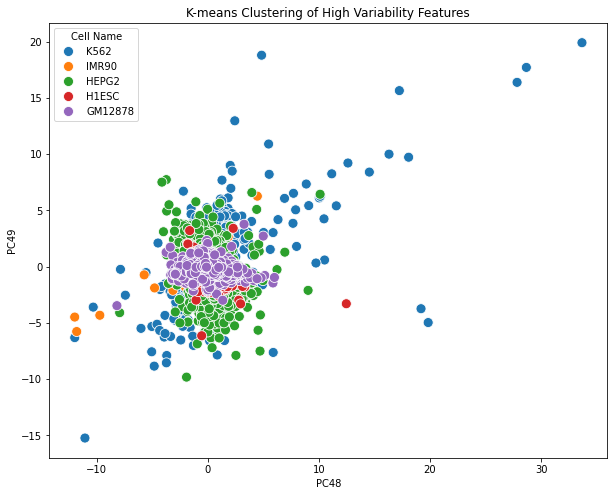

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


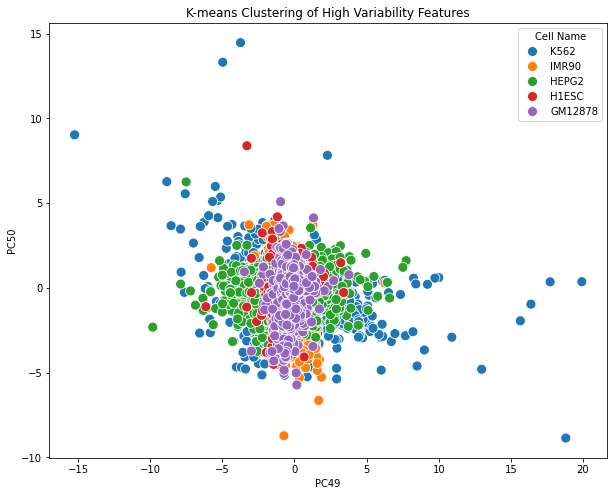

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


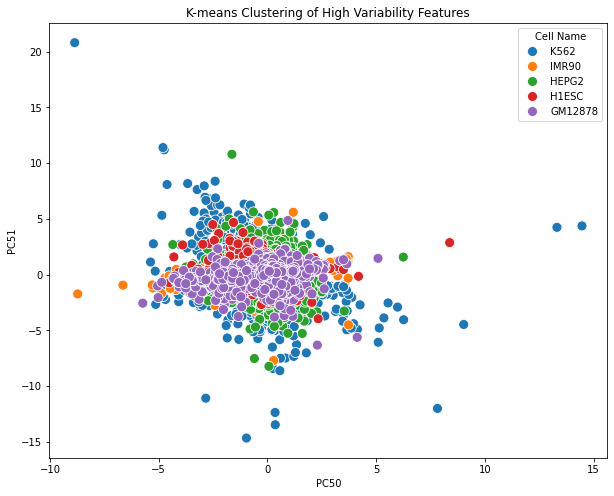

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


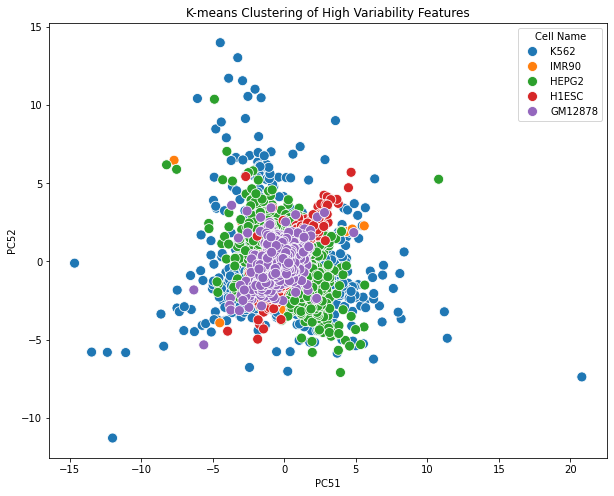

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


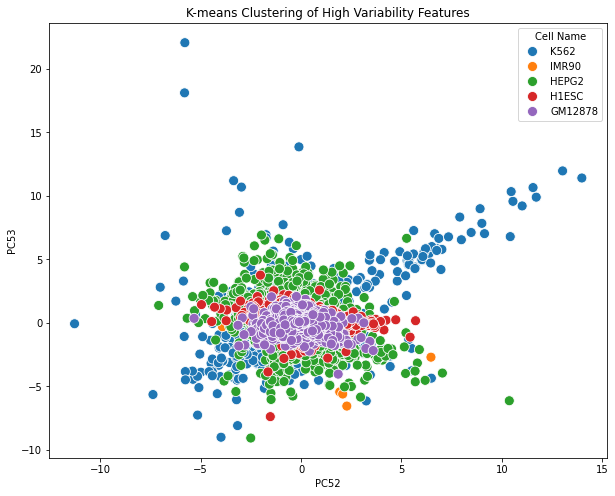

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


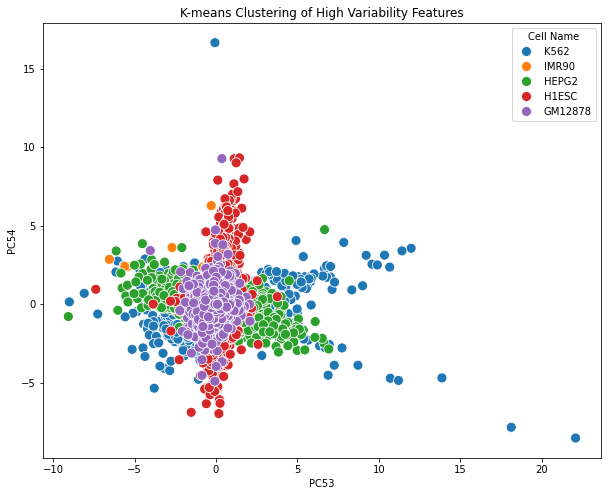

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


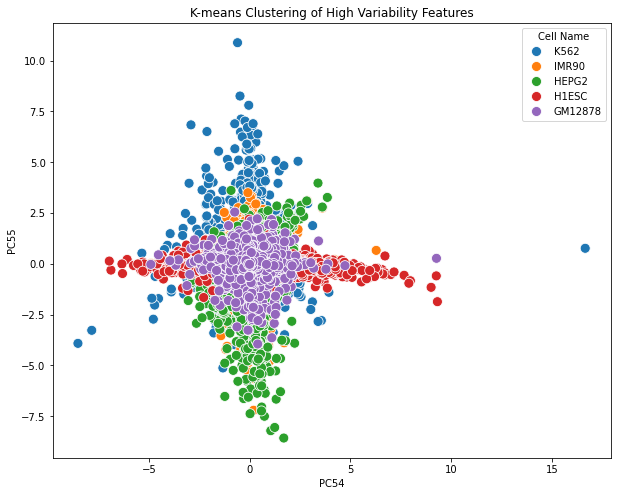

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


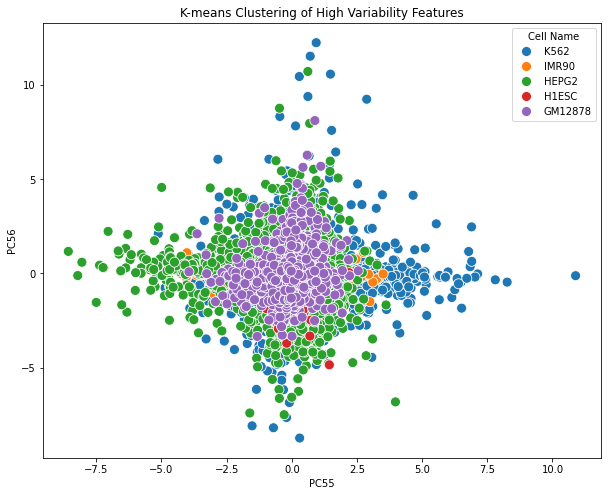

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


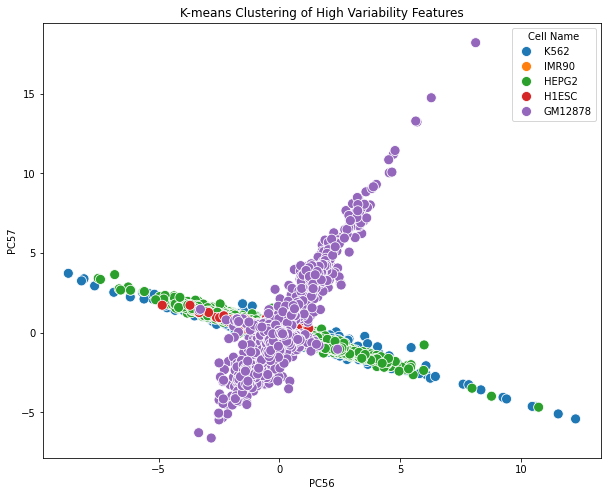

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


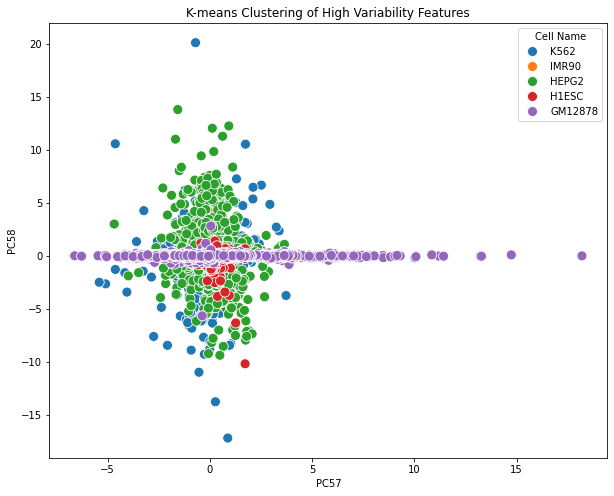

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


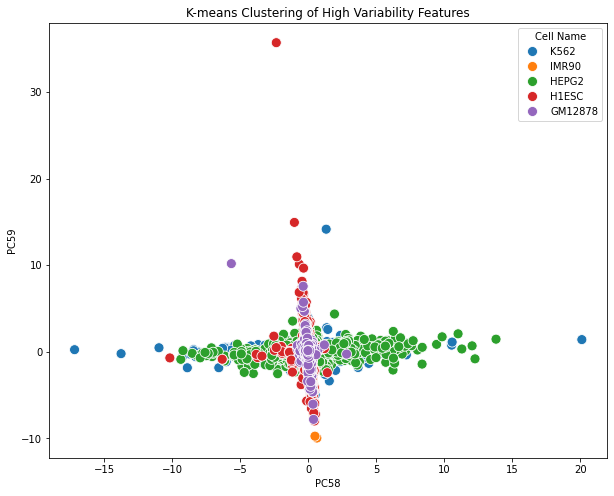

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


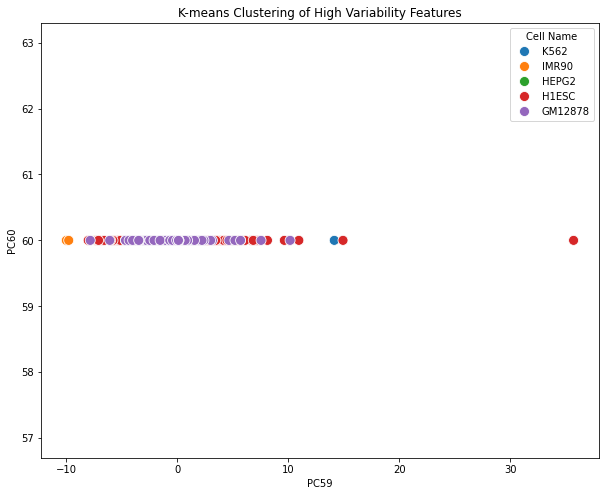

        PC1       PC2  Cluster     Sample
0 -0.099548 -0.286446        7  peak10000
1 -0.735805  0.003831       31  peak10001
2 -0.621949 -0.155483       21  peak10002
3  0.066861  0.851628       31  peak10003
4 -0.703433 -0.020058       31  peak10004


In [28]:
for i in range(index_90):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=percent_90_df, x=i, y=i+1, hue='Cell Name', palette='tab10', s=100)

    plt.xlabel('PC'+str(i))
    plt.ylabel('PC'+str(i+1))
    plt.title('K-means Clustering of High Variability Features')
    plt.legend(title='Cell Name')
    plt.show()

    print(clustered_features_df.head())

In [29]:
cell_labels = list(k562_table.columns)+list(imr90_table.columns)+list(hepg2_table.columns)+list(h1esc_table.columns)+list(gm12878_table.columns)
cell_type = ["K562"]*len(list(k562_table.columns))
cell_type += ["IMR90"]*len(list(imr90_table.columns))
cell_type += ["HEPG2"]*len(list(hepg2_table.columns))
cell_type += ["H1ESC"]*len(list(h1esc_table.columns))
cell_type += ["GM12878"]*len(list(gm12878_table.columns))
cell_labels_df = pd.DataFrame(np.array([cell_type, cell_labels]).T, columns=["Cell Name", "Peak Num"])
cell_labels_df["Index"] = cell_labels_df["Peak Num"].str.split("peak").str[1].astype("int32")
cell_labels_df = cell_labels_df.sort_values(by="Index")
cell_labels_df

Cell Name   Peak Num  Index
9996      HEPG2      peak0      0
9997      HEPG2      peak1      1
11108     HEPG2      peak2      2
12219     HEPG2      peak3      3
13330     HEPG2      peak4      4
...         ...        ...    ...
9991      IMR90  peak24995  24995
9992      IMR90  peak24996  24996
9993      IMR90  peak24997  24997
9994      IMR90  peak24998  24998
9995      IMR90  peak24999  24999

[24991 rows x 3 columns]

In [30]:
labels = ["K562"]*k562_table.shape[1]+["IMR90"]*imr90_table.shape[1]
labels += ["HEPG2"]*hepg2_table.shape[1]+["H1ESC"]*h1esc_table.shape[1]
labels += ["GM12878"]*gm12878_table.shape[1]

In [31]:
from sklearn.metrics import silhouette_score
silhouette_score(X=percent_90_df[np.arange(index_90)], labels=percent_90_df["Cell Name"])

-0.06973808258409861

In [32]:
cell_by_clusters = pd.merge(cell_labels_df, clustered_features_df, left_on="Peak Num", right_on="Sample")

from sklearn.metrics import rand_score, adjusted_rand_score
rand_score(list(cell_by_clusters["Cell Name"]), list(cell_by_clusters["Cluster"]))

0.6847147710270536

In [33]:
adjusted_rand_score(list(cell_by_clusters["Cell Name"]), list(cell_by_clusters["Cluster"]))

0.04177735198796956

In [34]:
from sklearn.metrics.cluster import adjusted_mutual_info_score

adjusted_mutual_info_score(list(cell_by_clusters["Cell Name"]), list(cell_by_clusters["Cluster"]))

0.2651027657992617

In [35]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PCA result to a DataFrame
pca_df = pd.DataFrame(np.array(percent_90_df[np.arange(index_90)]), columns=[f'PC_{i+1}' for i in range(index_90)])

# Display the PCA DataFrame
print("\nPCA DataFrame:")
print(pca_df.head())

# Apply UMAP to the principal components
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(pca_df)

# Convert UMAP result to a DataFrame
umap_df = pd.DataFrame(umap_result, columns=['UMAP_1', 'UMAP_2'])
umap_df["Cell Type"] = percent_90_df["Cell Name"]

# Display the UMAP DataFrame
print("\nUMAP DataFrame:")
print(umap_df.head())


PCA DataFrame:
       PC_1      PC_2      PC_3      PC_4      PC_5      PC_6      PC_7  \
0 -0.099548 -0.286446 -0.575533 -0.933445  0.922901 -0.767148  6.068484   
1 -0.735805  0.003831 -0.434639 -0.477567 -0.232955 -0.602724 -0.247878   
2 -0.621949 -0.155483 -0.455920 -0.113340 -0.057753 -0.371056  0.357509   
3  0.066861  0.851628 -0.389116 -0.346839  0.276352 -0.361457 -0.525537   
4 -0.703433 -0.020058 -0.444430 -0.471254 -0.349096 -0.503939 -0.272892   

       PC_8      PC_9     PC_10  ...     PC_51     PC_52     PC_53     PC_54  \
0  1.613370  0.804815  2.538311  ...  0.179103  0.391666 -0.360907 -0.939590   
1  0.043654 -0.025571 -0.038141  ... -0.027370  0.115681 -0.069205 -0.323795   
2  0.761872  0.109847  0.123030  ...  0.069642 -3.400520 -2.126875 -1.312228   
3 -0.401816  0.075833  0.887922  ...  0.394198  0.168665  0.114210 -0.113057   
4 -0.022727  0.081675  0.035726  ...  0.727058 -0.311674 -0.016780  0.687466   

      PC_55     PC_56     PC_57     PC_58     PC_59 

/home/users/arpitas/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



UMAP DataFrame:
     UMAP_1     UMAP_2 Cell Type
0  3.935774  17.750423      K562
1  7.348470  10.531814      K562
2  0.941193  15.917994      K562
3  2.484872  10.953525      K562
4  7.727854   8.878678      K562


[<matplotlib.lines.Line2D object at 0x7f7208c6af40>, <matplotlib.lines.Line2D object at 0x7f7219d768e0>, <matplotlib.lines.Line2D object at 0x7f7219d76c40>, <matplotlib.lines.Line2D object at 0x7f7219d76a30>, <matplotlib.lines.Line2D object at 0x7f7219d76370>]


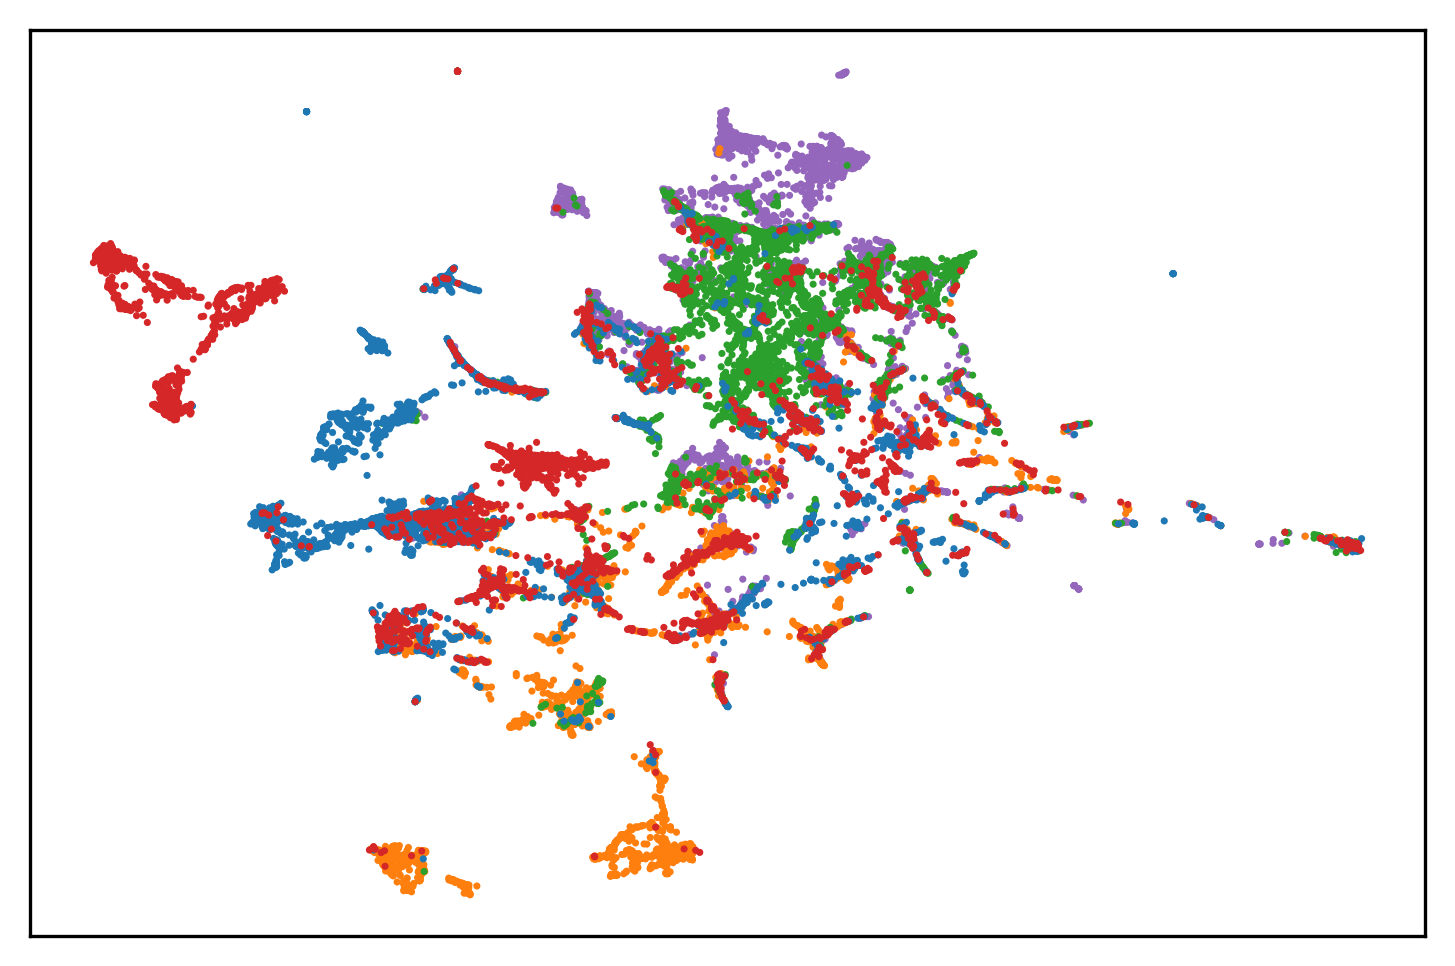

In [38]:
from matplotlib.colors import ListedColormap
plt.figure(dpi=300)
cmap = ListedColormap(["tab:red", "tab:blue", "tab:green", "tab:orange", "tab:purple"])
labels = umap_df["Cell Type"]
label_to_num = {'GM12878': 0, 'H1ESC': 1, 'HEPG2': 2, 'IMR90': 3, 'K562': 4}
c = [label_to_num[label] for label in labels]

scatter = plt.scatter(umap_df["UMAP_1"], umap_df["UMAP_2"], c=c, s=0.5, cmap=cmap)
plt.xticks([])
plt.yticks([])
# plt.title("Baseline")
print(scatter.legend_elements()[0])
categories = ["GM12878", "H1ESC", "HEPG2", "IMR90", "K562"]
# plt.legend(handles=scatter.legend_elements()[0], labels=categories)
# plt.savefig("/oak/stanford/groups/akundaje/projects/dnalm_benchmark/clusters/filteredpeaks_k50_pc60/baseline.png")
plt.show()